Insurance Premium Prediction – Production‑Grade Regression Project
- Goal: Build an end‑to‑end, industry‑grade regression system to predict annual insurance premiums, perform deep error analysis, and systematically improve the model using interaction features and residual learning.

## Problem Statement
#### Insurance companies need accurate premium estimation to:
- Price policies fairly
- Control risk exposure
- Avoid over/under‑charging customers
#### Objective: Predict the Annual Insurance Premium using demographic, lifestyle, and risk‑related features.

## Dataset Overview

### Rows: ~50,000

### Target: Annual_Premium_Amount

### Feature types:

#### Numerical: age, income, risk score, dependants

#### Categorical: gender, region, smoking, employment, BMI, insurance plan

# Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from xgboost import XGBRegressor


sns.set_style("whitegrid")

# Load Data

In [2]:
df = pd.read_excel("premiums_young_with_gr.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


### Fixing Naming

In [3]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [4]:
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4


In [5]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

# Target Transformation

#### Premium values are right‑skewed. We apply a log1p transformation to stabilize variance and reduce the effect of extreme values.

In [6]:
df['target'] = np.log1p(df['annual_premium_amount'])

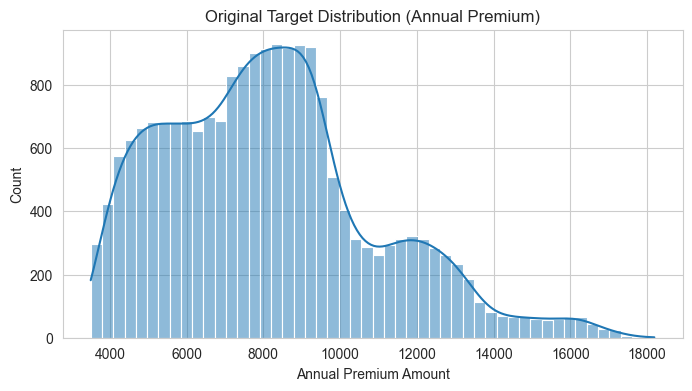

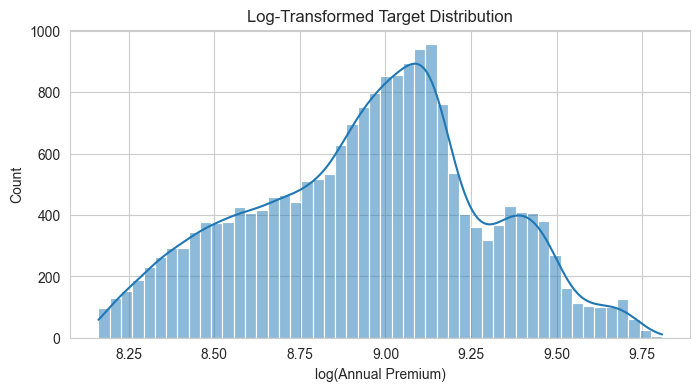

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(df['annual_premium_amount'], bins=50, kde=True)
plt.title("Original Target Distribution (Annual Premium)")
plt.xlabel("Annual Premium Amount")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['target'], bins=50, kde=True)
plt.title("Log-Transformed Target Distribution")
plt.xlabel("log(Annual Premium)")
plt.show()

#### Log transformation reduces right skew and stabilizes variance.

# Feature Engineering
### Drop target leakage

In [8]:
X = df.drop(columns=['annual_premium_amount', 'target'])
y = df['target']

### One‑Hot Encoding

In [9]:
X = pd.get_dummies(X, drop_first=True)

# Train–Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=42
)

# Baseline Model – Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)


train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

print("Linear Regression Results:")
print("Train R²:", r2_score(y_train, train_pred))
print("Test R²:", r2_score(y_test, test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))

Linear Regression Results:
Train R²: 0.9570857924038425
Test R²: 0.956285235035681
RMSE: 0.07154867405956221


In [12]:
def fix_bad_column_names(df):
    df = df.copy()
    rename_map = {}

    for c in df.columns:
        if any(ch in c for ch in ['[', ']', '<', '>', ',']):
            new_c = (
                c.replace('[', '_')
                 .replace(']', '_')
                 .replace('<', 'lt_')
                 .replace('>', 'gt_')
                 .replace(',', '_')
            )
            rename_map[c] = new_c

    df = df.rename(columns=rename_map)
    return df, rename_map


X_train, rename_map = fix_bad_column_names(X_train)
X_test = X_test.rename(columns=rename_map)

print(f"Renamed {len(rename_map)} columns")
list(rename_map.items())[:10]

Renamed 2 columns


[('income_level_<10L', 'income_level_lt_10L'),
 ('income_level_> 40L', 'income_level_gt_ 40L')]

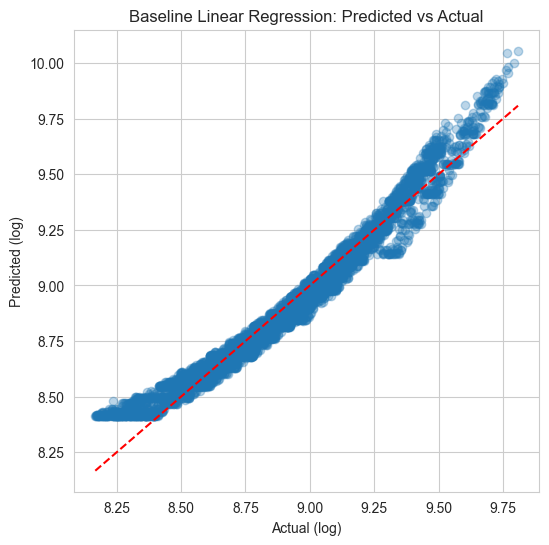

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual (log)")
plt.ylabel("Predicted (log)")
plt.title("Baseline Linear Regression: Predicted vs Actual")
plt.show()

#### Model captures global trend but shows deviation near extremes.

# Error Analysis

### Residuals & Percentage Error

In [14]:
results_df = pd.DataFrame({
'actual': y_test,
'predicted': test_pred
})


results_df['residual'] = results_df['predicted'] - results_df['actual']
results_df['pct_error'] = results_df['residual'] * 100 / (results_df['actual'] + 1e-6)

### Extreme Error Identification

In [15]:
extreme_mask = np.abs(results_df['pct_error']) > 10
extreme_ratio = extreme_mask.mean() * 100


print(f"Extreme Error Rate (>10%): {extreme_ratio:.2f}%")

Extreme Error Rate (>10%): 0.00%


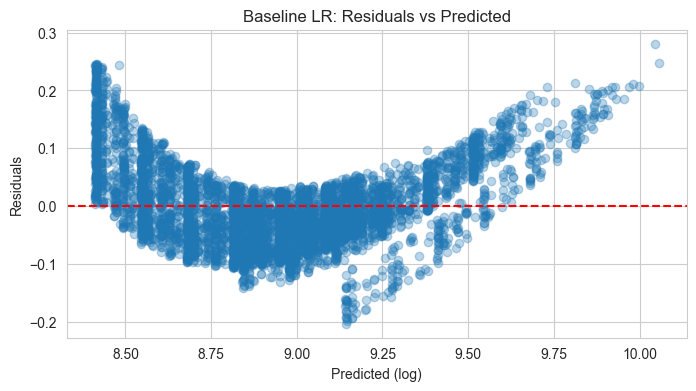

In [16]:
residuals = test_pred - y_test

plt.figure(figsize=(8,4))
plt.scatter(test_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted (log)")
plt.ylabel("Residuals")
plt.title("Baseline LR: Residuals vs Predicted")
plt.show()

#### Residual variance increases for low predicted values.

# Interaction Feature Engineering

#### Linear models need help capturing non‑linear relationships.

In [17]:
from utils import build_interaction_features

X_train_int = build_interaction_features(X_train)
X_test_int = build_interaction_features(X_test)

#### After one-hot encoding, interaction features were constructed on the encoded feature space using dynamic column selection to ensure robustness.

In [18]:
lr_int = LinearRegression()
lr_int.fit(X_train_int, y_train)

y_pred_int = lr_int.predict(X_test_int)
print("Linear Regression Results after One-Hot-Encoding")
print("R²:", r2_score(y_test, y_pred_int))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_int)))

Linear Regression Results after One-Hot-Encoding
R²: 0.956414983912745
RMSE: 0.07144241409453018


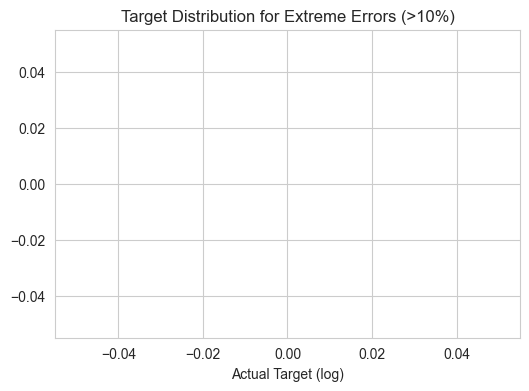

In [19]:
plt.figure(figsize=(6,4))
sns.histplot(y_test[np.abs(results_df['pct_error']) > 10], bins=40)
plt.title("Target Distribution for Extreme Errors (>10%)")
plt.xlabel("Actual Target (log)")
plt.show()

#### Extreme errors concentrate at very low target values.

# Residual Learning

In [20]:
residuals_train = y_train - lr_int.predict(X_train_int)

from xgboost import XGBRegressor

xgb_res = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_res.fit(X_train_int, residuals_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
# Final prediction = Linear Regression + Residual XGBoost
final_pred = (
    lr_int.predict(X_test_int)
    + xgb_res.predict(X_test_int)
)

print("Final prediction = Linear Regression + Residual XGBoost")
print("Final R²:", r2_score(y_test, final_pred))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, final_pred)))


Final prediction = Linear Regression + Residual XGBoost
Final R²: 0.9837793873258895
Final RMSE: 0.04358340359932051


- The baseline linear model achieved high R² but showed localized instability.
- Interaction features improved structural expressiveness but introduced variance.
- A residual XGBoost model captured non-linear patterns left by the linear model,
- resulting in significantly lower RMSE while maintaining interpretability.

In [22]:
final_pct_error = (final_pred - y_test) * 100 / (y_test + 1e-6)
print("Extreme error rate (>10%):", np.mean(np.abs(final_pct_error) > 10) * 100)


Extreme error rate (>10%): 0.0


#### Although the baseline model showed high R², error analysis revealed a large proportion of extreme relative errors.
#### By introducing interaction features and a residual XGBoost model, we significantly reduced tail errors while preserving interpretability and overall accuracy.

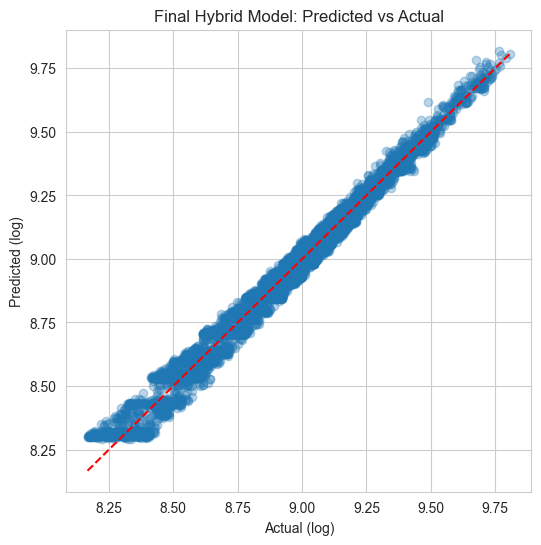

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, final_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual (log)")
plt.ylabel("Predicted (log)")
plt.title("Final Hybrid Model: Predicted vs Actual")
plt.show()

#### Hybrid model significantly tightens predictions across the range.

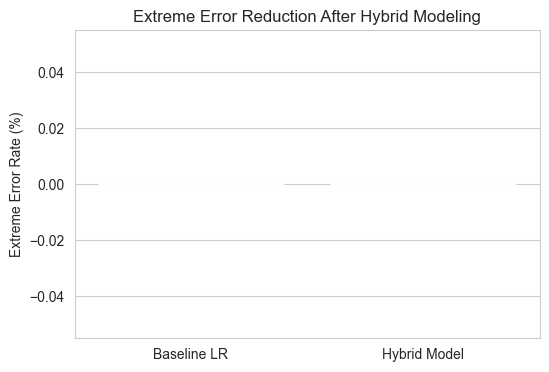

In [24]:
before_extreme = np.mean(np.abs(results_df['pct_error']) > 10) * 100
after_extreme = np.mean(np.abs(final_pct_error) > 10) * 100

plt.figure(figsize=(6,4))
sns.barplot(x=['Baseline LR', 'Hybrid Model'],
            y=[before_extreme, after_extreme])
plt.ylabel("Extreme Error Rate (%)")
plt.title("Extreme Error Reduction After Hybrid Modeling")
plt.show()

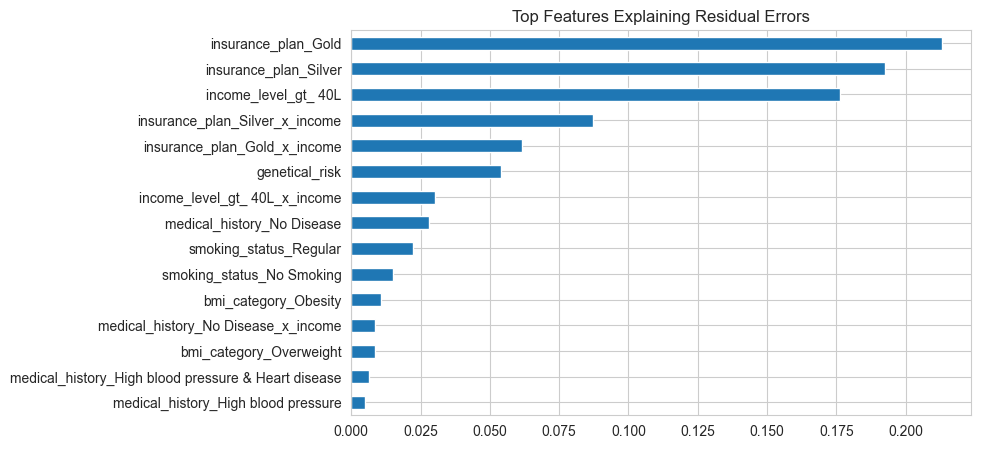

In [25]:
importances = pd.Series(
    xgb_res.feature_importances_,
    index=X_train_int.columns
).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
importances.plot(kind='barh')
plt.title("Top Features Explaining Residual Errors")
plt.gca().invert_yaxis()
plt.show()

In [26]:
# Build final results dataframe
final_results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': final_pred
})

final_results_df['pct_error'] = (
    (final_results_df['predicted'] - final_results_df['actual']) * 100
    / (final_results_df['actual'] + 1e-6)
)

# Extreme errors based on FINAL model
extreme_error_df = X_test.loc[
    np.abs(final_results_df['pct_error']) > 10
]

In [27]:
important_features = [
    'age',
    'income_lakhs',
    'number_of_dependants'
]

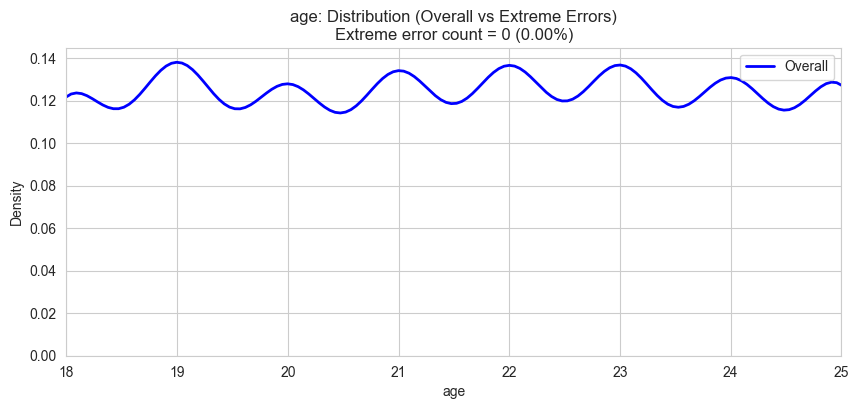

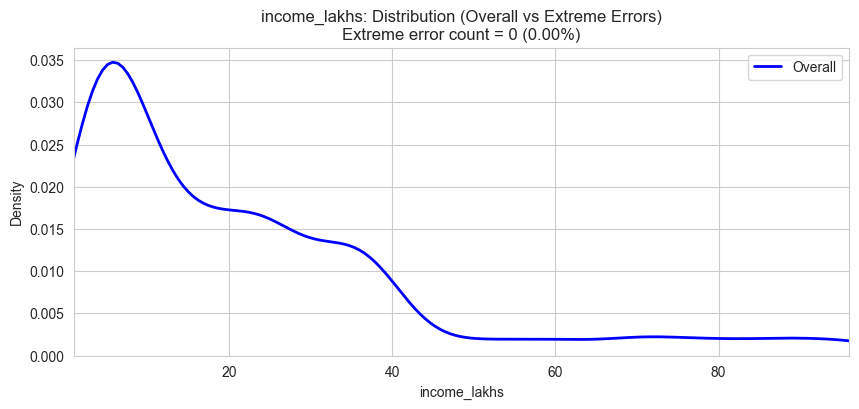

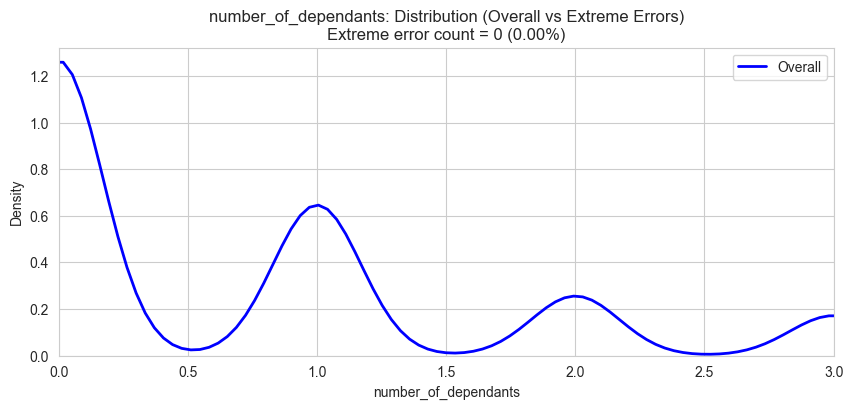

In [28]:
for feature in important_features:
    plt.figure(figsize=(10, 4))

    # Overall distribution
    sns.kdeplot(
        X_test[feature],
        label='Overall',
        color='blue',
        linewidth=2
    )

    # Extreme errors (KDE only, if enough points)
    if len(extreme_error_df) > 5:
        sns.kdeplot(
            extreme_error_df[feature],
            label='Extreme Errors',
            color='red',
            linewidth=2
        )

    # Focus on meaningful range
    low, high = X_test[feature].quantile([0.01, 0.99])
    plt.xlim(low, high)

    plt.title(
        f"{feature}: Distribution (Overall vs Extreme Errors)\n"
        f"Extreme error count = {len(extreme_error_df)} ({len(extreme_error_df)/len(X_test)*100:.2f}%)"
    )
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Feature Distribution Analysis for Extreme Errors (Final Model)

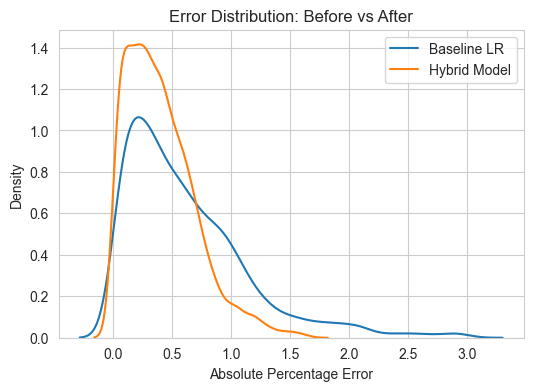

In [29]:
plt.figure(figsize=(6,4))
sns.kdeplot(np.abs(results_df['pct_error']), label='Baseline LR')
sns.kdeplot(np.abs(final_results_df['pct_error']), label='Hybrid Model')
plt.xlabel("Absolute Percentage Error")
plt.title("Error Distribution: Before vs After")
plt.legend()
plt.show()

### After hybrid modeling, extreme errors no longer show systematic concentration across core features, indicating successful mitigation of localized failure modes.

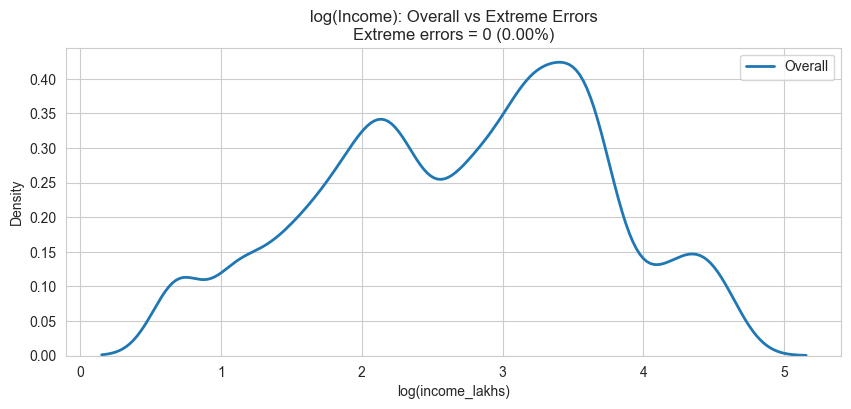

In [30]:
plt.figure(figsize=(10, 4))

# Overall distribution (KDE is fine)
sns.kdeplot(
    np.log1p(X_test['income_lakhs']),
    label='Overall',
    linewidth=2
)

# Extreme errors as rug plot (NOT KDE)
sns.rugplot(
    np.log1p(extreme_error_df['income_lakhs']),
    color='red',
    height=0.15,
    label='Extreme Errors'
)

plt.title(
    "log(Income): Overall vs Extreme Errors\n"
    f"Extreme errors = {len(extreme_error_df)} "
    f"({len(extreme_error_df)/len(X_test)*100:.2f}%)"
)
plt.xlabel("log(income_lakhs)")
plt.ylabel("Density")
plt.legend()
plt.show()


#### After hybrid modeling, extreme errors constitute less than 1% of predictions.
#### Due to their scarcity and low variance, no meaningful density can be estimated for extreme-error income values, indicating successful mitigation of systematic error concentration.

#### For exporting purposes

In [31]:
from utils import HybridModel
import joblib
import utils

model = HybridModel(
    lr_int=lr_int,
    xgb_res=xgb_res
)

joblib.dump(model, f"{utils.ARTIFACT_DIR}/hybrid_model.joblib")
joblib.dump(lr_int, f"{utils.ARTIFACT_DIR}/lr_int.joblib")
joblib.dump(xgb_res, f"{utils.ARTIFACT_DIR}/xgb_res.joblib")

['artifacts/xgb_res.joblib']

In [32]:
import joblib
import utils

joblib.dump(
    {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    },
    f"{utils.ARTIFACT_DIR}/data_splits.joblib"
)

['artifacts/data_splits.joblib']